# Unsupervised Learning - $\textit{Anomaly Detection}$

## 1. Importações

In [306]:
!pip install graphviz
!pip install xgboost
!pip install imblearn

In [307]:
# Carregar as funções compartilhadas do shared_functions.py
!curl -O https://raw.githubusercontent.com/Fraud-Detection-Handbook/fraud-detection-handbook/main/Chapter_References/shared_functions.py
%run shared_functions.py

# Pegar dados simulaos do repositório Github
if not os.path.exists("simulated-data-transformed"):
    !git clone https://github.com/Fraud-Detection-Handbook/simulated-data-transformed

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 63257  100 63257    0     0   243k      0 --:--:-- --:--:-- --:--:--  245k


<Figure size 640x480 with 0 Axes>

$\textit{Obs.: A saída está em vermelho, mas não indica erro.}$

In [308]:
from sklearn import metrics

# Sobrescrevendo a função do shared_functions.py para incluir o f1 score
def performance_assessment(predictions_df, output_feature='TX_FRAUD', 
                           prediction_feature='predictions', top_k_list=[100],
                           rounded=True,
                           threshold=0.5):
    
    AUC_ROC = metrics.roc_auc_score(predictions_df[output_feature], predictions_df[prediction_feature])
    AP = metrics.average_precision_score(predictions_df[output_feature], predictions_df[prediction_feature])
    
    # Binarizar previsões com o threshold especificado
    binary_preds = (predictions_df[prediction_feature] >= threshold).astype(int)
    F1 = metrics.f1_score(predictions_df[output_feature], binary_preds)
    
    performances = pd.DataFrame([[AUC_ROC, AP, F1]], 
                                columns=['AUC ROC','Average precision', 'F1 Score'])
    
    for top_k in top_k_list:
        _, _, mean_card_precision_top_k = card_precision_top_k(predictions_df, top_k)
        performances['Card Precision@'+str(top_k)] = mean_card_precision_top_k
        
    if rounded:
        performances = performances.round(3)
    
    return performances

## 2. Carregamento de dados (`Data Loading`)

In [309]:
DIR_INPUT='simulated-data-transformed/data/' 

BEGIN_DATE = "2018-06-11"
END_DATE = "2018-09-14"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

output_feature="TX_FRAUD"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']

Load  files
CPU times: total: 953 ms
Wall time: 1.17 s
919767 transactions loaded, containing 8195 fraudulent transactions


In [310]:
# Define o dia de início do período de treinamento, e os deltas
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train=7
delta_delay=7
delta_test=7


delta_valid = delta_test

start_date_training_with_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))

(train_df, valid_df)=get_train_test_set(transactions_df,start_date_training_with_valid,
                                       delta_train=delta_train,delta_delay=delta_delay,delta_test=delta_test)

# Por default, escala dados de entrada
(train_df, valid_df)=scaleData(train_df, valid_df,input_features)

## 3. Implementação do Autoencoder

In [311]:
SEED = 42

if torch.cuda.is_available():
    DEVICE = "cuda" 
else:
    DEVICE = "cpu"
print("Selected device is",DEVICE)

seed_everything(SEED)

Selected device is cpu


In [312]:
x_train = torch.FloatTensor(train_df[input_features].values)
x_valid = torch.FloatTensor(valid_df[input_features].values)
y_train = torch.FloatTensor(train_df[output_feature].values)
y_valid = torch.FloatTensor(valid_df[output_feature].values)

Adaptação do Dataset para o Autoencoder:

In [313]:
class FraudDatasetUnsupervised(torch.utils.data.Dataset):
    
    def __init__(self, x,output=True):
        'Initialization'
        self.x = x
        self.output = output

    def __len__(self):
        'Returns the total number of samples'
        return len(self.x)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample index
        item = self.x[index].to(DEVICE)
        if self.output:
            return item, item
        else:
            return item

In [314]:
training_set = FraudDatasetUnsupervised(x_train)
valid_set = FraudDatasetUnsupervised(x_valid)

training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64) #Função para geração de DataLoaders a partir do dataset

Autoencoder:

In [315]:
class SimpleAutoencoder(torch.nn.Module):
    
        def __init__(self, input_size, intermediate_size, code_size):
            super(SimpleAutoencoder, self).__init__()
            # parametros
            self.input_size = input_size
            self.intermediate_size = intermediate_size           
            self.code_size  = code_size
            
            self.relu = torch.nn.ReLU()   
            
            #encoder
            self.fc1 = torch.nn.Linear(self.input_size, self.intermediate_size)
            self.fc2 = torch.nn.Linear(self.intermediate_size, self.code_size)
            
            #decoder 
            self.fc3 = torch.nn.Linear(self.code_size, self.intermediate_size)            
            self.fc4 = torch.nn.Linear(self.intermediate_size, self.input_size)
            
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            hidden = self.relu(hidden)
            
            code = self.fc2(hidden)
            code = self.relu(code)
 
            hidden = self.fc3(code)
            hidden = self.relu(hidden)
            
            output = self.fc4(hidden)
            #saída linear          
            
            return output

In [316]:
criterion = torch.nn.MSELoss().to(DEVICE)

## 4. Detecção de fraudes (não supervisionada)

In [317]:
def per_sample_mse(model, generator):
    
    model.eval()
    criterion = torch.nn.MSELoss(reduction="none")
    batch_losses = []
    
    for x_batch, y_batch in generator:
        # Forward pass
        y_pred = model(x_batch)
        # Compute Loss
        loss = criterion(y_pred.squeeze(), y_batch)
        loss_app = list(torch.mean(loss,axis=1).detach().cpu().numpy())
        batch_losses.extend(loss_app)
    
    return batch_losses

In [318]:
seed_everything(SEED)
model = SimpleAutoencoder(x_train.shape[1], 100, 20).to(DEVICE)
losses = per_sample_mse(model, valid_generator)

In [319]:
print(losses[0:5])
print(np.mean(losses))

[0.6754841, 0.79146266, 1.1697072, 0.8070149, 1.258897]
0.9325165


### 4.1 Treinamento

In [320]:
seed_everything(SEED)

training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)

criterion = torch.nn.MSELoss().to(DEVICE)

model = SimpleAutoencoder(len(input_features), 100,20).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [321]:
model,training_execution_time,train_losses,valid_losses = training_loop(model,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        max_epochs=500,
                                                                        verbose=True)


Epoch 0: train loss: 0.4457241622072219
valid loss: 0.11789107639444331
New best score: 0.11789107639444331

Epoch 1: train loss: 0.08445224025594801
valid loss: 0.044737972811760146
New best score: 0.044737972811760146

Epoch 2: train loss: 0.03813445719535931
valid loss: 0.028129153183656313
New best score: 0.028129153183656313

Epoch 3: train loss: 0.02394556577707397
valid loss: 0.016839738651255116
New best score: 0.016839738651255116

Epoch 4: train loss: 0.013857098703627006
valid loss: 0.009604490618603152
New best score: 0.009604490618603152

Epoch 5: train loss: 0.007683125645078961
valid loss: 0.005340869447389424
New best score: 0.005340869447389424

Epoch 6: train loss: 0.005279009854803876
valid loss: 0.004115886983202129
New best score: 0.004115886983202129

Epoch 7: train loss: 0.004053559081707271
valid loss: 0.003136056854486303
New best score: 0.003136056854486303

Epoch 8: train loss: 0.0030781877174595974
valid loss: 0.0025031250393873113
New best score: 0.0025031

`Early Stopping` na época 51.

### 4.2 Avaliação do modelo

In [322]:
losses = per_sample_mse(model, valid_generator)
print(losses[0:5])
print(np.mean(losses))

[3.35583e-05, 3.1533546e-05, 3.7850186e-05, 4.6781686e-05, 3.4615405e-05]
7.209741e-05


In [323]:
print(x_train[0])
print(model(x_train[0].to(DEVICE)))

tensor([-0.1323, -0.6306,  2.1808, -0.3003,  0.1241, -1.6917,  0.5035, -1.6630,
        -0.0482, -0.9810, -0.0816, -1.9895, -0.1231, -0.9719, -0.1436])
tensor([-0.1370, -0.6276,  2.1797, -0.2948,  0.1179, -1.6992,  0.5020, -1.6770,
        -0.0482, -0.9776, -0.0745, -1.9811, -0.1188, -0.9687, -0.1389],
       grad_fn=<ViewBackward0>)


In [324]:
genuine_losses = np.array(losses)[y_valid.cpu().numpy() == 0]
fraud_losses = np.array(losses)[y_valid.cpu().numpy() == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))

Average fraud reconstruction error: 0.0014036155
Average genuine reconstruction error: 6.3530766e-05


In [325]:
predictions_df=valid_df.copy()
predictions_df['predictions']=losses
    
result1 = performance_assessment(predictions_df, threshold = 0.001)
result1

,AUC ROC,Average precision,F1 Score,Card Precision@100
0,0.839,0.165,0.281,0.199


### 4.3 Curva de $\textit{Precision-Recall}$

In [326]:
def plot_precision_recall_curve(y_true, y_scores, ax, title, fs, baseline):
    precision, recall, _ = metrics.precision_recall_curve(y_true, y_scores)

    ax.plot(recall, precision, color='b', alpha=0.8, label='Precision-Recall curve')
    ax.set_title(title, fontsize=fs)
    ax.set_xlim([-0.01, 1.01])
    ax.set_ylim([-0.01, 1.01])

    ax.set_xlabel('Recall (True Positive Rate)', fontsize=fs)
    ax.set_ylabel('Precision', fontsize=fs)

    ax.plot([0, 1], [baseline, baseline], 'r--', label='AP Random = {0:0.3f}'.format(baseline))
    ax.legend(loc="lower left", fontsize=fs*0.8)
    return

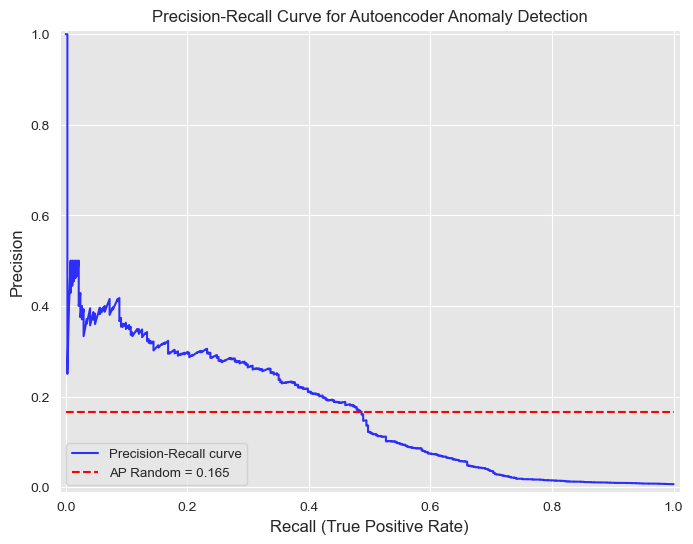

In [327]:
from sklearn.metrics import average_precision_score, precision_recall_curve
import matplotlib.pyplot as plt

# Calcular a precisão média para o baseline
average_precision = average_precision_score(predictions_df[output_feature], predictions_df['predictions'])

# Plotting da Curva de Precision-Recall
fig, ax = plt.subplots(figsize=(8, 6))
plot_precision_recall_curve(
    y_true=predictions_df[output_feature],
    y_scores=predictions_df['predictions'],
    ax=ax,
    title='Precision-Recall Curve for Autoencoder Anomaly Detection',
    fs=12,
    baseline=average_precision
)
plt.show()

## 5. Variação dos métodos de Amostragem

O método "sem nada" foi já avaliado nas células acima ( `get_train_test_set(sampling_ratio=1.0)`). 
Dessa forma temos os seguintes métodos a serem avaliados:
- Oversampling;
- Undersampling.

### 5.1 Oversampling

In [328]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# Separação dos features e do target
X_train_resample = train_df[input_features]
y_train_resample = train_df[output_feature]

# RandomOverSampler
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_resample, y_train_resample)

# Converter de volta para DataFrame
train_df_resampled = pd.DataFrame(X_resampled, columns=input_features)
train_df_resampled[output_feature] = y_resampled

# Criação do training_set
x_train = torch.FloatTensor(train_df_resampled[input_features].values)
y_train = torch.FloatTensor(train_df_resampled[output_feature].values) # Keep y_train for potential future use or if you adapt the dataset class

training_set = FraudDatasetUnsupervised(x_train)
valid_set = FraudDatasetUnsupervised(x_valid)

#### Treinamento

In [329]:
seed_everything(SEED)

training_generator, valid_generator = prepare_generators(training_set, valid_set, batch_size=64)

criterion = torch.nn.MSELoss().to(DEVICE)

OS = SimpleAutoencoder(len(input_features), 100,20).to(DEVICE)

optimizer = torch.optim.Adam(OS.parameters(), lr = 0.0001)

OS,training_execution_time,train_losses,valid_losses = training_loop(OS,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        max_epochs=500,
                                                                        patience=2,
                                                                        verbose=True)


Epoch 0: train loss: 0.9511604004514378
valid loss: 0.0997266007414281
New best score: 0.0997266007414281

Epoch 1: train loss: 0.053781496924545945
valid loss: 0.03707915507256985
New best score: 0.03707915507256985

Epoch 2: train loss: 0.023219714225287832
valid loss: 0.01622829659348303
New best score: 0.01622829659348303

Epoch 3: train loss: 0.01344432110509846
valid loss: 0.011489046858674516
New best score: 0.011489046858674516

Epoch 4: train loss: 0.007625145251205565
valid loss: 0.005062429487572912
New best score: 0.005062429487572912

Epoch 5: train loss: 0.003746520075115508
valid loss: 0.0033501795999441152
New best score: 0.0033501795999441152

Epoch 6: train loss: 0.002741934545911241
valid loss: 0.0026754480544884836
New best score: 0.0026754480544884836

Epoch 7: train loss: 0.002174187183935684
valid loss: 0.0021766856451432316
New best score: 0.0021766856451432316

Epoch 8: train loss: 0.0017714579463248684
valid loss: 0.0017877320986739843
New best score: 0.00178

`Early Stopping` na época 61.

#### Avaliação

In [330]:
losses_OS = per_sample_mse(OS, valid_generator)
print(losses_OS[0:5])
print(np.mean(losses_OS))

[1.37783345e-05, 8.390302e-06, 5.299761e-06, 1.819799e-05, 1.5390668e-05]
4.359615e-05


In [331]:
genuine_losses = np.array(losses_OS)[y_valid.cpu().numpy() == 0]
fraud_losses = np.array(losses_OS)[y_valid.cpu().numpy() == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))

Average fraud reconstruction error: 0.00015856806
Average genuine reconstruction error: 4.285645e-05


In [332]:
predictions_df_OS=valid_df.copy()
predictions_df_OS['predictions']=losses_OS
    
result2 = performance_assessment(predictions_df_OS, threshold = 0.001)
result2

,AUC ROC,Average precision,F1 Score,Card Precision@100
0,0.815,0.032,0.021,0.033


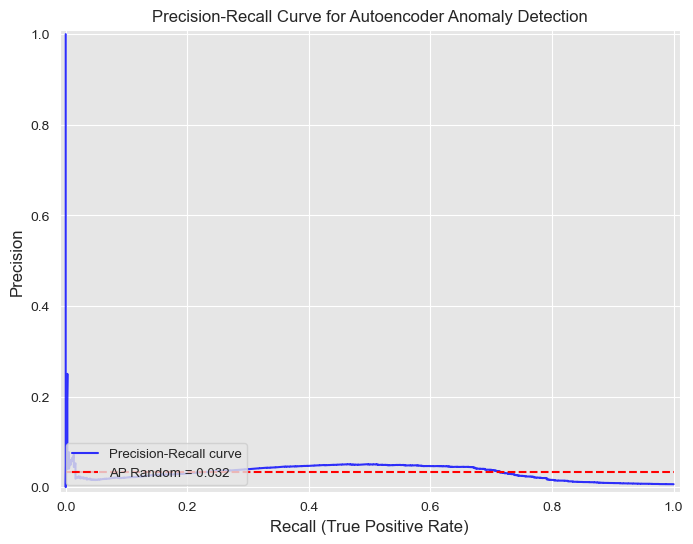

In [333]:
average_precision = average_precision_score(predictions_df_OS[output_feature], predictions_df_OS['predictions'])

# Plotting da Curva de Precision-Recall
fig, ax = plt.subplots(figsize=(8, 6))
plot_precision_recall_curve(
    y_true=predictions_df_OS[output_feature],
    y_scores=predictions_df_OS['predictions'],
    ax=ax,
    title='Precision-Recall Curve for Autoencoder Anomaly Detection',
    fs=12,
    baseline=average_precision
)
plt.show()

### 5.2 Undersampling

In [334]:
(train_df, valid_df) = get_train_test_set(
    transactions_df,
    start_date_training_with_valid,
    delta_train=delta_train,
    delta_delay=delta_delay,
    delta_test=delta_test,
    sampling_ratio=0.5 # subsample to 50%
)

# scaling
(train_df, valid_df) = scaleData(train_df, valid_df, input_features)

x_train = torch.FloatTensor(train_df[input_features].values)
x_valid = torch.FloatTensor(valid_df[input_features].values)
y_train = torch.FloatTensor(train_df[output_feature].values)
y_valid = torch.FloatTensor(valid_df[output_feature].values)

training_set = FraudDatasetUnsupervised(x_train)
valid_set = FraudDatasetUnsupervised(x_valid)

### Treinamento

In [335]:
seed_everything(SEED)

training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)

criterion = torch.nn.MSELoss().to(DEVICE)

US = SimpleAutoencoder(len(input_features), 100,20).to(DEVICE)

optimizer = torch.optim.Adam(US.parameters(), lr = 0.0001)

US,training_execution_time,train_losses,valid_losses = training_loop(US,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        max_epochs=500,
                                                                        verbose=True)


Epoch 0: train loss: 0.6952806051329035
valid loss: 0.28819116927235505
New best score: 0.28819116927235505

Epoch 1: train loss: 0.19649126979007775
valid loss: 0.11902363273859676
New best score: 0.11902363273859676

Epoch 2: train loss: 0.10442716842713137
valid loss: 0.07444574251119557
New best score: 0.07444574251119557

Epoch 3: train loss: 0.0615872154778037
valid loss: 0.043778893948008456
New best score: 0.043778893948008456

Epoch 4: train loss: 0.040223525213807766
valid loss: 0.0335394536577613
New best score: 0.0335394536577613

Epoch 5: train loss: 0.03267000004093574
valid loss: 0.02755393966360659
New best score: 0.02755393966360659

Epoch 6: train loss: 0.02672884306811637
valid loss: 0.022656688513488718
New best score: 0.022656688513488718

Epoch 7: train loss: 0.021714588707352118
valid loss: 0.018103028004327434
New best score: 0.018103028004327434

Epoch 8: train loss: 0.016631200603328743
valid loss: 0.013131737661206982
New best score: 0.013131737661206982

Ep

`Early Stopping` na época 77.

### Avaliação

In [336]:
losses_US = per_sample_mse(US, valid_generator)
print(losses_US[0:5])
print(np.mean(losses_US))

[5.2055064e-05, 7.6958575e-05, 9.0547604e-05, 6.815417e-05, 8.855619e-05]
0.00013738808


In [337]:
genuine_losses = np.array(losses_US)[y_valid.cpu().numpy() == 0]
fraud_losses = np.array(losses_US)[y_valid.cpu().numpy() == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))

Average fraud reconstruction error: 0.002801159
Average genuine reconstruction error: 0.00012025005


In [338]:
predictions_df_US=valid_df.copy()
predictions_df_US['predictions']=losses_US
    
result3 = performance_assessment(predictions_df_US, threshold = 0.001)
result3

,AUC ROC,Average precision,F1 Score,Card Precision@100
0,0.837,0.182,0.284,0.211


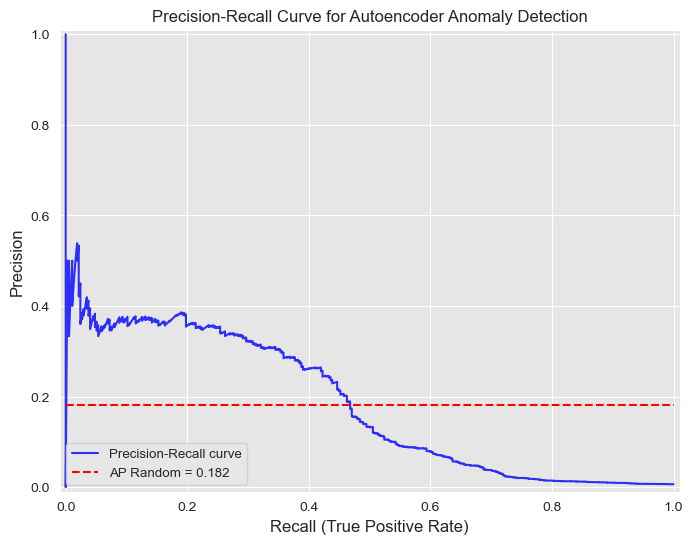

In [339]:
average_precision = average_precision_score(predictions_df_US[output_feature], predictions_df_US['predictions'])

# Plotting da Curva de Precision-Recall
fig, ax = plt.subplots(figsize=(8, 6))
plot_precision_recall_curve(
    y_true=predictions_df_US[output_feature],
    y_scores=predictions_df_US['predictions'],
    ax=ax,
    title='Precision-Recall Curve for Autoencoder Anomaly Detection',
    fs=12,
    baseline=average_precision
)
plt.show()

## Avaliação Conjunta dos Métodos de sampling

In [340]:
comparison_df = pd.DataFrame({
    'Model': ['Baseline', 'Oversampling', 'Undersampling'],
    'F1 Score': [
        result1['F1 Score'].values[0],
        result2['F1 Score'].values[0],
        result3['F1 Score'].values[0]
    ],
    'Average Precision': [
        result1['Average precision'].values[0],
        result2['Average precision'].values[0],
        result3['Average precision'].values[0]
    ]
})

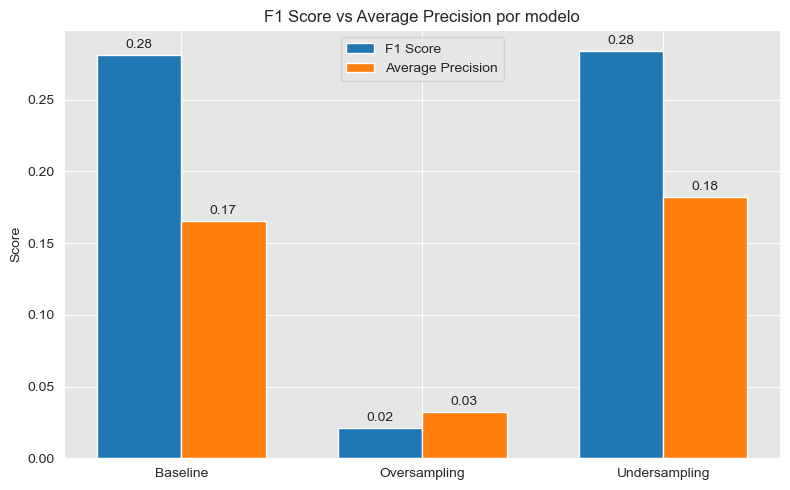

In [341]:
# Dados
labels = comparison_df['Model']
f1_scores = comparison_df['F1 Score']
average_precisions = comparison_df['Average Precision']

x = np.arange(len(labels))  # localização dos grupos
width = 0.35  # largura das barras

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, f1_scores, width, label='F1 Score')
rects2 = ax.bar(x + width/2, average_precisions, width, label='Average Precision')

# Labels e layout
ax.set_ylabel('Score')
ax.set_title('F1 Score vs Average Precision por modelo')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Adicionar valores nas barras
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()